## Code to find intersections of ICESat-2 and ATM data

**by Allison Chartrand**

**June 2019 ICESat-2 Hackweek**


In [1]:
#IMPORT PACKAGES
import os
import glob
import pandas as pd
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import pyproj
from scipy.spatial import distance

Code to extract single tracks of IceSat-2 data

In [2]:
ATL06data = pd.read_csv('../extractData/IceSat2ZachData')

In [3]:
ATL06data['track'].unique()

array(['gt3r', 'gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l'], dtype=object)

In [4]:
ATL06data.date.unique()

array(['2019-01-04 12:24:25', '2019-02-15 10:09:55',
       '2018-10-29 05:05:08', '2019-01-16 01:09:49',
       '2018-11-23 03:49:31', '2018-12-10 02:50:30',
       '2018-12-19 12:57:40', '2019-01-08 01:26:37',
       '2018-11-20 14:21:44', '2018-12-26 02:17:13',
       '2019-02-17 23:37:46', '2018-11-16 14:30:09',
       '2018-11-27 03:41:06', '2018-12-27 12:41:01',
       '2018-10-21 05:21:45', '2018-12-23 12:49:22',
       '2018-10-22 15:45:34', '2018-12-14 02:42:09',
       '2018-12-15 13:05:59', '2019-01-20 01:01:33',
       '2018-12-18 02:33:52', '2019-01-13 11:42:01',
       '2019-01-29 11:08:55', '2018-11-15 04:06:22',
       '2018-11-19 03:57:57', '2018-12-02 13:56:37',
       '2018-10-17 05:30:05', '2019-01-17 11:33:37',
       '2018-10-25 05:13:27', '2018-10-30 15:28:58',
       '2019-01-21 11:25:25', '2019-02-13 23:46:06',
       '2018-10-26 15:37:16', '2019-01-28 00:45:05',
       '2019-01-12 01:18:14', '2018-12-30 02:08:55',
       '2019-01-25 11:17:11', '2018-12-31 12:3

Define dataframe for output

In [61]:
Intersections = {'Flow_dist_ATM':[],'z_ATM':[],'idx_ATM':[],'z_ATL06':[],'t_ATL06':[],'idx_ATL06':[],'gt_ATL06':[]}
Intersections = pd.DataFrame(data = Intersections)

print(Intersections.head())
ATL06data.head()

Empty DataFrame
Columns: [Flow_dist_ATM, z_ATM, idx_ATM, z_ATL06, t_ATL06, idx_ATL06, gt_ATL06]
Index: []


,lon,lat,h,track,date,x,y
0,-22.520585,78.700068,579.33765,gt3r,2019-01-04 12:24:25,469494.782922,-1.134613e+06
1,-22.520755,78.700244,579.03015,gt3r,2019-01-04 12:24:25,469484.057930,-1.134597e+06
2,-22.520925,78.700420,578.78815,gt3r,2019-01-04 12:24:25,469473.331404,-1.134581e+06
3,-22.521094,78.700596,578.57214,gt3r,2019-01-04 12:24:25,469462.614457,-1.134564e+06
4,-22.521264,78.700773,578.33830,gt3r,2019-01-04 12:24:25,469451.884907,-1.134548e+06


Define nearest neighbor algorithm

In [6]:
def closest_node(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    closest_dist = np.min(distance.cdist([node], nodes,'euclidean'))
    return closest_index, closest_dist

Get target points from ATM csv and put into dataframe

In [78]:
ATMdata = pd.read_csv('~/xtrak/extractData/atmZach04_18_19.csv')

tpoints = ATMdata[['PS_x','PS_y']].copy()
tpoints = tpoints.values
ATMdata.head()

,ATM_long,ATM_lat,PS_x,PS_y,ATM_elev,dist_along
0,334.846721,79.211271,397913.477068,-1.102426e+06,891.4235,0.000000
1,334.848221,79.211989,397915.704090,-1.102342e+06,891.6056,84.231835
2,334.849722,79.212707,397917.946244,-1.102257e+06,891.7156,168.470291
3,334.848567,79.212155,397916.203061,-1.102322e+06,891.6397,233.240595
4,334.848296,79.211153,397948.158670,-1.102427e+06,891.1921,342.853729


Make an empty dataframe for intersections
Get query points from ATL06 csv and put into dataframe
Loop through unique dates and ground tracks and find the closest point between each ground track and the flowline
Store intersection along-flow distance, z_ATM, z_ATL06 and other helpful data in Intersections dataframe

In [119]:
Intersections = {'Flow_dist_ATM':[],'z_ATM':[],'idx_ATM':[],'z_ATL06':[],'t_ATL06':[],'idx_ATL06':[],'gt_ATL06':[]}
Intersections = pd.DataFrame(data = Intersections)
i = 0
for day in ATL06data.date.unique()[0:10]:

    for tr in ATL06data.track.unique():
        close_idx = []
        min_dist = []
        AddDatarow = []

        #dfTran is a single radar transect
        dfTran = ATL06data.query('date == @day & track == @tr')
        if dfTran.shape[0] == 0:
            continue
            
        
        qpoints = dfTran[['x','y']].copy()
        qpoints = qpoints.values

        
        for j in range(len(tpoints)):
            close_idxT,min_distT = closest_node(tpoints[j,:], qpoints)
            close_idx = np.append(close_idx,[close_idxT])
            min_dist = np.append(min_dist,[min_distT])
        if min(min_dist) > 1000:
            continue
        
        tpt_idx = np.argmin(min_dist)
        qpt_idx = int(close_idx[tpt_idx])
        dfTran_idx = dfTran.loc[dfTran['date'] == day].index[0]
        qpt_idx = qpt_idx+dfTran_idx
        
        AddDatarow = {'Flow_dist_ATM':[ATMdata.loc[tpt_idx,'dist_along']],
                      'z_ATM':[ATMdata.loc[tpt_idx,'ATM_elev']],
                      'idx_ATM':[tpt_idx],
                      'z_ATL06':[dfTran.loc[qpt_idx,'h']],
                      't_ATL06':[dfTran.loc[qpt_idx,'date']],
                      'idx_ATL06':[qpt_idx],
                      'gt_ATL06':[dfTran.loc[qpt_idx,'track']]}
        AddDatarow = pd.DataFrame(data = AddDatarow)
        Intersections = Intersections.append(AddDatarow)
        

(3377, 2)
the query index is  1572
(3361, 2)
the query index is  4940
(3875, 2)
the query index is  39466
(3922, 2)
the query index is  19988
(3929, 2)
the query index is  23922
(3919, 2)
the query index is  27843
(3905, 2)
the query index is  31765
(3862, 2)
the query index is  35608
(3977, 2)
the query index is  62805
(3940, 2)
the query index is  43123
(3949, 2)
the query index is  47065
(3935, 2)
the query index is  50987
(3944, 2)
the query index is  54929
(3964, 2)
the query index is  58829
(3070, 2)
the query index is  76481
(1364, 2)
the query index is  64521
(1384, 2)
the query index is  65906
(2211, 2)
the query index is  68102
(2229, 2)
the query index is  70344
(3049, 2)
the query index is  73398
(3837, 2)
the query index is  98538
(3944, 2)
the query index is  78975
(3950, 2)
the query index is  82908
(3964, 2)
the query index is  86858
(3965, 2)
the query index is  90825
(3855, 2)
the query index is  94698
(3956, 2)
the query index is  124271
(3963, 2)
the query index is 

   Flow_dist_ATM     z_ATM  idx_ATM     z_ATL06              t_ATL06  \
0   1.437161e+06   36.0352  13645.0   35.310593  2019-02-15 10:09:55   
0   1.437877e+06   35.7798  13651.0   35.218838  2019-02-15 10:09:55   
0   1.008148e+06   87.1343  10346.0   69.219765  2019-01-16 01:09:49   
0   1.102527e+06   57.8883  11073.0   27.613283  2019-01-16 01:09:49   
0   1.101290e+06   29.4266  11063.0   42.196710  2019-01-16 01:09:49   
0   1.050723e+06   30.0488  10675.0   74.656880  2019-01-16 01:09:49   
0   1.048440e+06   57.6435  10656.0   56.679836  2019-01-16 01:09:49   
0   1.009318e+06   90.1790  10356.0   69.153725  2019-01-16 01:09:49   
0   5.854236e+05  433.0671   6992.0  430.857500  2018-11-23 03:49:31   
0   6.794339e+05  248.8764   7759.0  246.065860  2018-11-23 03:49:31   
0   6.778121e+05  245.0844   7749.0  241.688610  2018-11-23 03:49:31   
0   6.268962e+05  319.5400   7378.0  309.104580  2018-11-23 03:49:31   
0   6.259390e+05  319.3689   7371.0  309.190640  2018-11-23 03:4

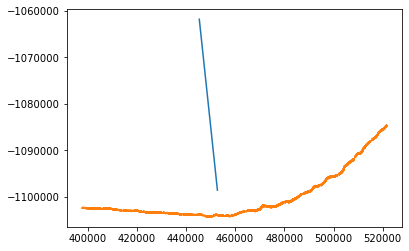

In [117]:
print(Intersections)


In [118]:

Intersections.to_csv('~/xtrak/extractData/Intersections.csv',index=False)